In [19]:
%load_ext autoreload
%autoreload 3
from Probe import get_pdata, probe_shapelet
import numpy as np
import utils
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [4]:
from tsai.models.FCN import FCN
model_path = 'models/GunPoint/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = utils.read_UCR_UEA('GunPoint', None)
test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)

instance_length = train_x.shape[-1]

with open(f'shapelets/GunPoint/RSTF.pkl', 'rb') as f:
    ST_attribution = pickle.load(f)
# pick the first Shapelet
info_gain, shapelet_length, start_pos, dimension, inst_index, shapelet_class, z_norm_shapelet = ST_attribution.shapelets[0]

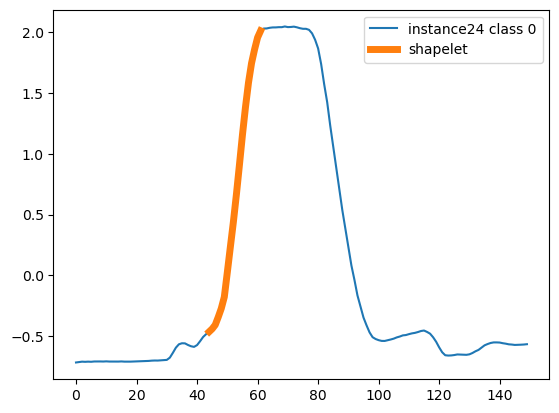

In [48]:
plt.plot(train_x[inst_index].flatten(),label=f'instance{inst_index} class {shapelet_class}')
plt.plot(np.arange(start_pos,start_pos+shapelet_length),train_x[inst_index,:,start_pos:start_pos+shapelet_length].flatten(),
         linewidth=5,label='shapelet')
plt.legend()

In [150]:
shapelet = train_x[2,:,90:107].flatten()
# shapelet = z_norm_process_shapelet(shapelet)

In [151]:
pdata = get_pdata(shapelet=shapelet, selected_datasets=utils.selected_uni, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                       is_z_norm=True, save_dir='probe/GunPoint_implet')

dealing with ECG200: (100, 1, 96)
dealing with Beef: (30, 1, 470)
dealing with ElectricDevices: (8926, 1, 96)
dealing with Earthquakes: (322, 1, 512)
dealing with Wafer: (1000, 1, 152)
dealing with PowerCons: (180, 1, 144)
dealing with NonInvasiveFetalECGThorax1: (1800, 1, 750)
dealing with ECG5000: (500, 1, 140)
dealing with HandOutlines: (1000, 1, 2709)
dealing with CBF: (30, 1, 128)
dealing with FordA: (3601, 1, 500)
dealing with TwoPatterns: (1000, 1, 128)
dealing with UWaveGestureLibraryAll: (896, 1, 945)
dealing with Chinatown: (20, 1, 24)
dealing with Yoga: (300, 1, 426)
dealing with DistalPhalanxOutlineCorrect: (600, 1, 80)
dealing with Computers: (250, 1, 720)
dealing with ShapesAll: (600, 1, 512)
dealing with Strawberry: (613, 1, 235)


In [157]:
with open('probe/GunPoint_implet/pdata.pkl','rb') as f:
    pdata = pickle.load(f)

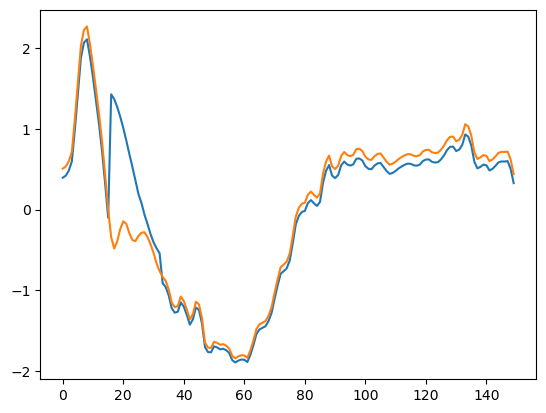

In [158]:
plt.plot(pdata['pdata_ws'][0].flatten(),label='with shapelet')
plt.plot(pdata['pdata_wos'][0].flatten(),label='without shapelet')

In [159]:
pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=0)

In [179]:
3360/2

1680.0

In [160]:
print(pdata.shape)

(3360, 1, 150)


In [190]:
results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, 
                         shapelet=shapelet, pos=start_pos, device='cuda:1',save_path='probe/GunPoint_implet',
                         shapelet_labels=[None, [0]*1680+[1]*1680],
                         is_threshold_info_gain=True)

(50, 128) (3360, 128)
Training Accuracy = 0.79
Testing Accuracy = 0.79
----------------------
Accuracy = 0.48


In [192]:
with open('probe/GunPoint_implet/probe_latent_label.pkl', 'rb') as f:
    probe_latent_label = pickle.load(f)
dataset_s_distances = probe_latent_label['dataset_s_distances']
pdata_s_distances = probe_latent_label['pdata_s_distances']
# best_threshold = probe_latent_label['best_threshold']
dataset_s_label = probe_latent_label['dataset_s_label']
pdata_s_label = probe_latent_label['pdata_s_label']
dataset_latent = probe_latent_label['dataset_latent']
pdata_latent = probe_latent_label['pdata_latent']

In [174]:
best_threshold

0.0023637299576189114

In [193]:
print(np.count_nonzero([i==1 for i in pdata_s_label]))
print(np.count_nonzero([i==0 for i in pdata_s_label]))

print(np.count_nonzero([i==1 for i in dataset_s_label]))
print(np.count_nonzero([i==0 for i in dataset_s_label]))

1680
1680
16
34


In [194]:
with open('probe/GunPoint_implet/results.pkl', 'rb') as f:
    results = pickle.load(f)
pred_train = results['pred_train']
pred_test = results['pred_test']
dataset_s_pred = results['dataset_s_pred']
print(np.count_nonzero([i==0 for i in dataset_s_pred]))
print(np.count_nonzero([i==1 for i in dataset_s_pred]))

10
40


In [195]:
len(dataset_s_label)

50

In [196]:
label = np.zeros(len(pdata_s_label)+len(dataset_s_label),dtype=np.uint8)
for i in range(len(pdata_s_label)+len(dataset_s_label)):
    if i<3360 and pdata_s_label[i]==0:
        label[i] = 0
    elif i<3360 and pdata_s_label[i]==1:
        label[i] = 1 
    elif i>=3360 and dataset_s_label[i-3360]==0:
        label[i] = 2
    elif i>=3360 and dataset_s_label[i-3360]==1:
        label[i] = 3

In [197]:
dataset_latent.shape

(50, 128)

In [207]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=20)
latent_vis = tsne.fit_transform(np.concatenate((pdata_latent,dataset_latent)))

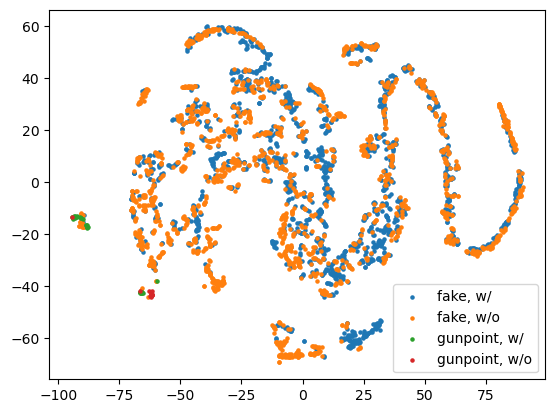

In [208]:
plt.scatter(latent_vis[label == 0, 0], latent_vis[label == 0, 1], label='fake, w/', s=5)
plt.scatter(latent_vis[label == 1, 0], latent_vis[label == 1, 1], label='fake, w/o', s=5)
plt.scatter(latent_vis[label == 2, 0], latent_vis[label == 2, 1], label='gunpoint, w/', s=5, color=plt.get_cmap('tab10')(2))
plt.scatter(latent_vis[label == 3, 0], latent_vis[label == 3, 1], label='gunpoint, w/o', s=5, color=plt.get_cmap('tab10')(3))

plt.legend()
plt.savefig('probe/GunPoint_implet/tsne.png')

In [ ]:
probe_shapelet(dataset=train_x, labels=train_y, pdata=test_x, model=model, 
                         shapelet=shapelet, pos=start_pos, device='cuda:1')